In [2]:
import os
# import sys, math
import numpy as np
import skimage
from skimage import exposure, filters#, feature
from skimage import color
# from skimage.color import rgb2gray
from skimage.feature import hog

import matplotlib.pyplot as plt
# from scipy.stats import circmean

root_folder = os.getcwd()
print('current working directory:', root_folder)

current working directory: c:\Users\u0135479\Documents\GitHub\directionality


In [3]:
from pipeline_utils import load_and_prepare_image

def reshape_hog_array(array, len_axis1):
    # Calculate the total number of elements in the array
    N = array.size
    # Ensure that m is a divisor of N
    if N % len_axis1 != 0:
        raise ValueError(f"The given len_axis1 ({len_axis1}) is not a divisor of the total number of elements ({N}).")
    
    new_shape = (N // len_axis1, len_axis1)
    # Reshape the array
    reshaped_array = array.reshape(new_shape)
    return reshaped_array


def clean_black_hogs(array, threshold):
    return


def linear_hist_to_polar(hist_data, figsize=(3,3)):
    """
    Plot a histogram of directions in polar coordinates.
        hist_data (list or np.array): Array or list containing histogram values for each direction bin.
    """
    n_bins = len(hist_data)
    # Generate bin angles
    bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)  # +1 to close the circle
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Middle of each bin

    # Create polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=figsize)
    bars = ax.bar(bin_centers, hist_data, width=(2 * np.pi / n_bins), bottom=0)

    # Optional: Set the direction of the zero angle
    ax.set_theta_zero_location('N')  # North
    ax.set_theta_direction(-1)  # Clockwise
    plt.show()


def linear_hist_to_polar_in_grid(hist_data, ax, y_lim=2):
    """
    Plot a histogram of directions in polar coordinates on a given axis.
    
    Parameters:
        hist_data (list or np.array): Array containing histogram values for each direction bin.
        ax (matplotlib.axes.Axes): The axis on which to plot the histogram.
    """
    n_bins = len(hist_data)
    # Generate bin angles
    bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)  # +1 to close the circle
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Middle of each bin

    # Plot the histogram on the given axis
    ax.bar(bin_centers, hist_data, width=(2 * np.pi / n_bins), bottom=0)
    ax.set_theta_zero_location('N')  # North
    ax.set_theta_direction(-1)  # Clockwise
    if y_lim is not None:
        ax.set_ylim(0, y_lim)


class HOGDescriptor:
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), channel_axis=-1):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.channel_axis = channel_axis
        self.fd = None
        self.hog_image = None

    def get_orientations(self):
        return self.orientations
    

    def compute_hog(self, image, visualize=True,
                block_norm=None, feature_vector=False, channel_axis=-1):
        
        """Compute Histogram of Oriented Gradients (HOG) RGB or grayscale image."""
        if channel_axis is None or str(channel_axis).lower() == 'grayscale':
            image = color.rgb2gray(image)
            channel_axis = None
        
        if visualize:
            self.fd, self.hog_image = hog(image, orientations=self.orientations, 
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block,
                                visualize=visualize,
                                block_norm=block_norm,
                                feature_vector=feature_vector, channel_axis=channel_axis)
        else:
            self.fd  = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, visualize=False,\
                        block_norm=block_norm, feature_vector=feature_vector,
                        channel_axis=channel_axis)
            self.hog_image = None

        # return fd, hog_image
        return self.fd, self.hog_image


from matplotlib.ticker import FormatStrFormatter
import math

def polar_histogram(fd, ax, n_orientations=20, ytick_format="%.2g", y_lim=None):
    # Assuming reshape_hog_array is a function that reshapes the flat descriptor array
    fd_reshaped = reshape_hog_array(fd, len_axis1=n_orientations)
    
    # Sum the histograms across all cells/blocks
    global_histogram = np.sum(fd_reshaped, axis=0)
    
    bin_angles = np.linspace(0, 360, n_orientations, endpoint=False)
    bin_angles_rad = np.deg2rad(bin_angles)
    
    # Find the bin with the maximum value
    max_index = np.argmax(global_histogram)
    max_value = global_histogram[max_index]

    n_bins = len(global_histogram)
    # Generate bin angles
    bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)  # +1 to close the circle
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Middle of each bin

    # Plot the histogram on the given axis
    ax.bar(bin_centers, global_histogram, width=(2 * np.pi / n_bins), bottom=0)

    ax.set_theta_zero_location('N')  # North
    ax.set_theta_direction(-1)  # Clockwise
    if y_lim is not None:
        ax.set_ylim(0, y_lim)
    
    # Plot the histogram in polar coordinates on the provided axis
    # bars = ax.bar(bin_angles_rad, global_histogram, width=np.deg2rad(360/n_orientations), bottom=0.0)
    # bars[max_index].set_color('red')

    max_y_tick = math.ceil(max_value/0.2)*0.2
    ax.set_yticks(np.linspace(0, max_y_tick, num=4))  # Adjust the number of ticks here
    ax.yaxis.set_major_formatter(FormatStrFormatter(ytick_format))

    # Return the most occurring value and its bin angle in degrees
    return bin_angles, max_index

In [4]:
def plot_directional_histograms(fd, N=None, M=None, fd_data_as_array=True, plot_build=True, show=True, minifig_size=(3, 3), verbose=0):
    """
    Plot HOG directional histograms in a grid of polar subplots.
    Parameters:
        fd (numpy.ndarray): Array containing HOG features with shape (blocks_x, blocks_y, cells_per_block_x, cells_per_block_y, orientations).
    """
    if N is None:
        N = fd.shape[0]
    if M is None:
        M = fd.shape[1]

    fd_data = {"grid_size": (N, M)
               }
    
    if plot_build:
        # Create a figure with a grid of subplots
        fig, axes = plt.subplots(N, M, subplot_kw={'projection': 'polar'}, figsize=(minifig_size[0]*M+0.5, minifig_size[1]*N+0.5))

    est_max = fd.mean(axis=(2, 3)).max() 
    if verbose > 0:
        print("estimated max y-scale:", 1.1*est_max)

    key = 0
    for i in range(N):
        for j in range(M):
            plot_fd = fd[i, j, :, :, :].mean(axis=(0, 1))  # Average over sub-cells (cells_per_block_x, cells_per_block_y)
            
            if plot_build:
                ax = axes[i, j] if N > 1 and M > 1 else axes[max(i, j)] #2D or 1D axes grid, according to the case
                linear_hist_to_polar_in_grid(plot_fd, ax=ax,y_lim=1.1*est_max)
            
            key += 1
            fd_data[key] = plot_fd
    
    if plot_build:
        plt.tight_layout()
        if show:
            plt.show()

    if fd_data_as_array:
        vectors = []
        for key, value in fd_data.items():
            if key == 'grid_size':
                continue  # Skip the 'grid_size' key
            # Append the vector to the list
            vectors.append(value)

        # Convert the list of vectors to a 2D numpy array
        fd_data = np.array(vectors)
    return fd_data



def compute_directional_histogram(fd, N=None, M=None, fd_data_as_array=True):
    if N is None:
        N = fd.shape[0]
    if M is None:
        M = fd.shape[1]

    fd_data = {"grid_size": (N, M)}
    key = 0
    for i in range(N):
        for j in range(M):
            plot_fd = fd[i, j, :, :, :].mean(axis=(0, 1))  # Average over sub-cells (cells_per_block_x, cells_per_block_y)
            key += 1
            fd_data[key] = plot_fd


    if fd_data_as_array:
        vectors = []
        for key, value in fd_data.items():
            if key == 'grid_size':
                continue  # Skip the 'grid_size' key
            # Append the vector to the list
            vectors.append(value)
        # Convert the list of vectors to a 2D numpy array
        fd_data = np.array(vectors)
    return fd_data



In [5]:
image_path = os.path.join(root_folder, 'images-data')
image = load_and_prepare_image(image_path, 'trial_image_1.tif')

hog_descriptor = HOGDescriptor(orientations=30, pixels_per_cell=(20, 20), cells_per_block=(1, 1),
                               channel_axis=-1)
fd , hog_image  = hog_descriptor.compute_hog(image, block_norm=None, feature_vector=False)
## fd is of shape (cells_H_axis, cells_W_axis, Blocks_per_cell_H, Blocks_per_cell_W, n_orientations)

# PLOT_BUILD = False if hog_image.size > 400*300 else True
# the plot_directional_histograms collects the histogram distribution for every cell:
# fd_data = plot_directional_histograms(fd, plot_build=PLOT_BUILD)
# fd_data_final = fd_data.mean(0)


fd_data = compute_directional_histogram(fd)
# outputs dataframe with  shape: (cells_H_axis, cells_W_axis, N_ORS)

intensities = fd_data.mean(1) # average entry per cell. Many of these are noisy: to be dropped
threshold = np.percentile(intensities, 75)

cells_to_consider = np.array([intensity > threshold for intensity in intensities])

fd_data_final = fd_data[cells_to_consider,:].mean(0) # average ov every direction intensity across remaining cells

# correct strong signal at 0 and 180 degrees (happens a lot with constant black backgournd)
fd_data_final[0] = 0.5*(fd_data_final[1] + fd_data_final[-1])
fd_data_final[round(len(fd_data_final)/2)] = 0.5*(fd_data_final[round(len(fd_data_final)/2)+1] + fd_data_final[round(len(fd_data_final)/2)-1])


From raw data (local, for each Histogram), to a global histogram (taking element-wise average)

Load image here ( first step of pipeline) and try out already

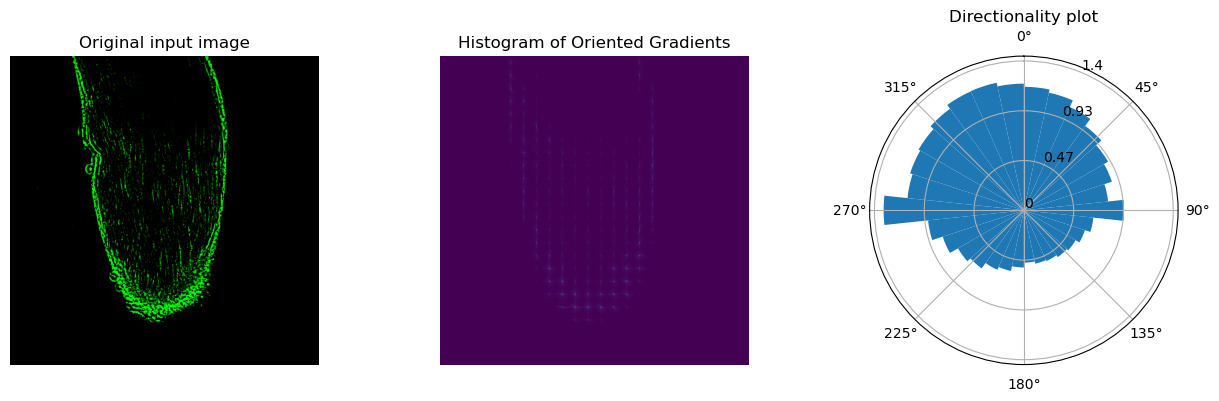

In [17]:
fig = plt.figure(figsize=(13, 4))
# Explicitly create each subplot separately within the figure, specifying projection='polar' to ax3 
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3, projection='polar')
ax1.axis('off')
ax1.imshow(image)  # 'image' should be defined previously
ax1.set_title('Original input image')

# hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 
ax2.axis('off')
ax2.imshow(hog_image)#, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

# Pass the pre-defined axis object 'ax3' which is already set to be a polar plot
N_ORS = hog_descriptor.get_orientations()
estim_ymax = fd_data_final.max() 
bin_angles, max_idx = polar_histogram(fd_data_final, ax3, n_orientations=N_ORS, y_lim=1.1*estim_ymax)

ax3.set_title('Directionality plot')

plt.tight_layout()
plt.show()

Compute average direction and deviation from it:

In [18]:
def compute_average_direction(global_histogram):

    if global_histogram.ndim > 1:
        raise ValueError('Input should be 1D, got shape {global_histogram.shape} instead ')

    n_orientations = len(global_histogram)

    bin_angles = np.linspace(0, 180, n_orientations, endpoint=False)
    bin_angles_rad = np.deg2rad(bin_angles)
    
    # # Convert histogram values to vectors (double the angle for periodicity)
    # x = np.sum(global_histogram * np.cos(2 * bin_angles_rad))
    # y = np.sum(global_histogram * np.sin(2 * bin_angles_rad))

    # Convert histogram values to vectors
    x = np.sum(global_histogram * np.cos(bin_angles_rad))
    y = np.sum(global_histogram * np.sin(bin_angles_rad))

    # Calculate the resultant vector's angle (mean direction)
    mean_angle_rad = np.arctan2(y, x) # this, or 0.5 * np.arctan2(y, x) if previous step was doubling stuff
    mean_angle_deg = np.rad2deg(mean_angle_rad)
    
    # Adjust the mean angle to be within the range (-90, 90]
    if mean_angle_deg > 90:
        mean_angle_deg -= 180
    
    # Calculate angle residuals (in rads)
    angle_diffs = np.abs(np.deg2rad(bin_angles) - mean_angle_rad)
    angle_diffs = np.minimum(angle_diffs, np.pi - angle_diffs) #take minimum difference between diff angle and its supplementary

    # Calculate the standard deviation (sqrt of the average squared residuals)
    # weighted by histogram height, and normalised.
    std_dev = np.sqrt(np.sum(global_histogram * angle_diffs**2) / np.sum(global_histogram))
    std_dev_deg = np.rad2deg(std_dev)
    
    # Calculate average of absolute residuals)
    # weighted by histogram height, and normalised.
    avg_dev = np.sum(np.abs(global_histogram * angle_diffs) / np.sum(global_histogram))
    avg_dev_deg = np.rad2deg(avg_dev)

    return mean_angle_deg, std_dev_deg, avg_dev_deg


out1, out2, out3 = compute_average_direction(fd_data_final)
print(out1, out2, out3)


n_orientations = len(fd_data_final)

bin_angles = np.linspace(0, 180, n_orientations, endpoint=False)
bin_angles_rad = np.deg2rad(bin_angles)

# Convert histogram values to vectors
x1 = np.sum(fd_data_final * np.cos(bin_angles_rad))
y1 = np.sum(fd_data_final * np.sin(bin_angles_rad))
print("deg1:", np.rad2deg(np.arctan2(y1, x1))) # this, or 0.5 * np.arctan2(y, x) if previous step was doubling stuff

# Convert histogram values to vectors
x2 = np.sum(fd_data_final * np.cos(2*bin_angles_rad))
y2 = np.sum(fd_data_final * np.sin(2*bin_angles_rad))
print("deg2:", np.rad2deg(0.5*np.arctan2(y2, x2))) # this, or 0.5 * np.arctan2(y, x) if previous step was doubling stuff



-85.93192093434904 56.802706161638355 51.05520024764722
deg1: 94.06807906565096
deg2: -14.155698296085435


### Exploratory analysis for HOG is complete!

### Now scale up, iterate over images and report numbers

image file: 20240507 fkt19 P2 CTR R1.2 deblurr_z057c1.tif
average direction  :  3.88 degrees.
standard deviation :  46.94 degrees
mean abs. deviation:  39.39 degrees


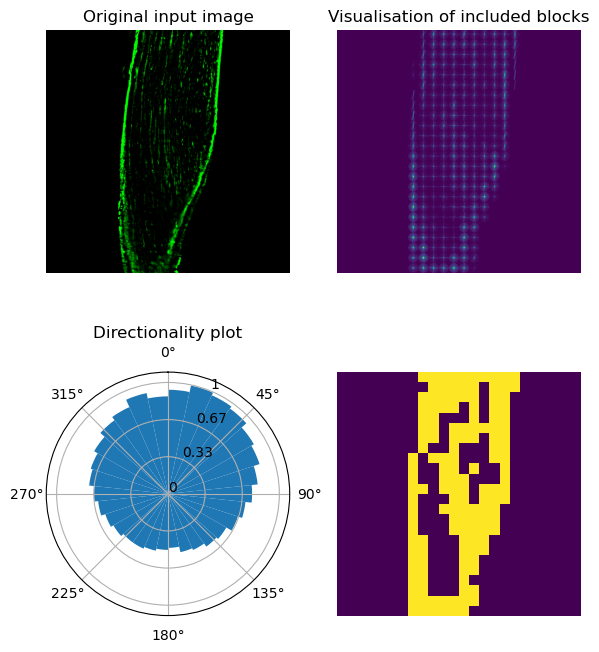

image file: 20240507 fkt19 P2 CTR R1.2 deblurr_z058c1.tif
average direction  :  3.19 degrees.
standard deviation :  46.89 degrees
mean abs. deviation:  39.31 degrees


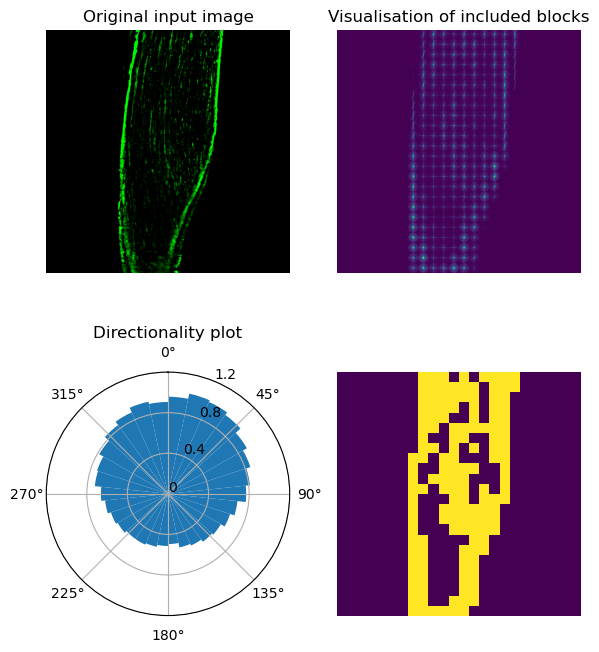

image file: 20240507 fkt19 P2 CTR R1.2 deblurr_z059c1.tif
average direction  :  4.10 degrees.
standard deviation :  46.77 degrees
mean abs. deviation:  39.16 degrees


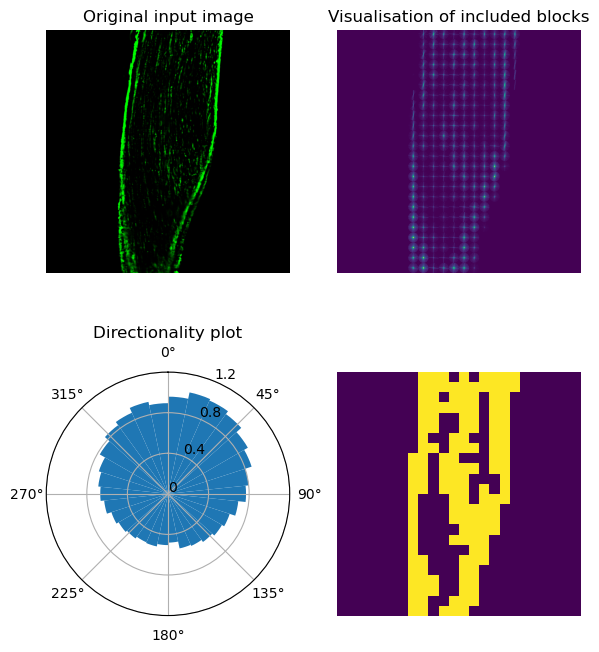

image file: 20240507 fkt19 P2 CTR R1.2 deblurr_z067c1.tif
average direction  :  6.03 degrees.
standard deviation :  46.21 degrees
mean abs. deviation:  38.42 degrees


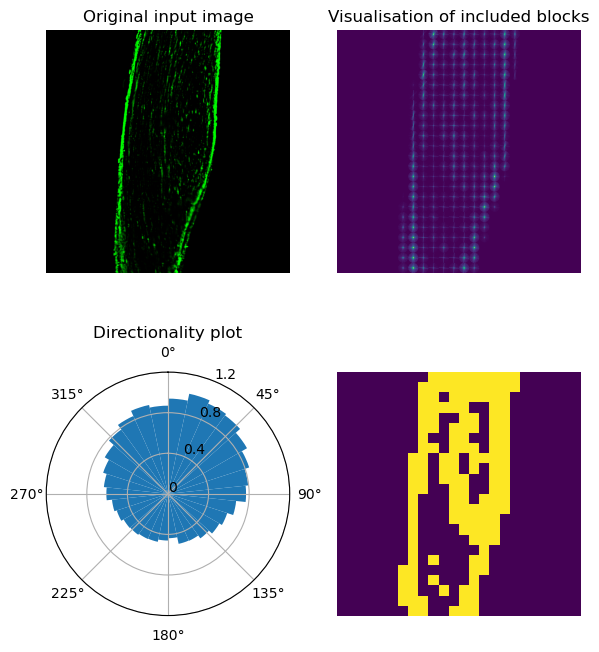

image file: 20240507 fkt19 P2 CTR R1.2 deblurr_z073c1.tif
average direction  :  6.67 degrees.
standard deviation :  46.13 degrees
mean abs. deviation:  38.39 degrees


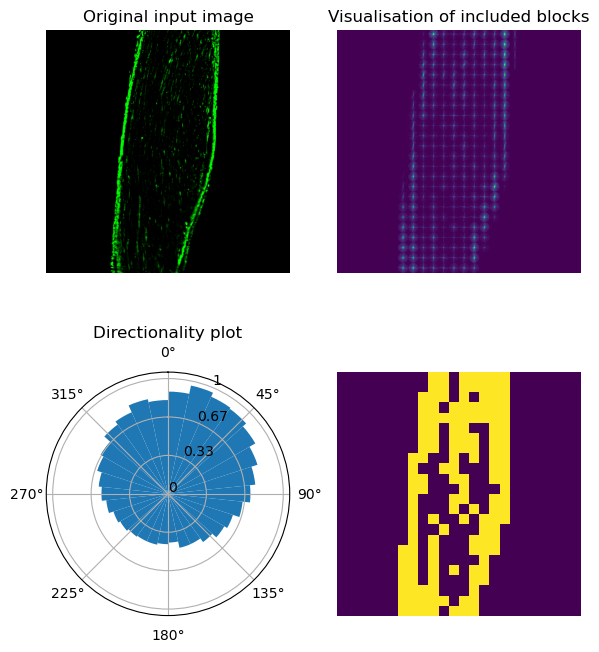

image file: 20240507 fkt19 P2 CTR R1.4-Deblurring_z22c1.tif
average direction  : -1.99 degrees.
standard deviation :  45.30 degrees
mean abs. deviation:  37.88 degrees


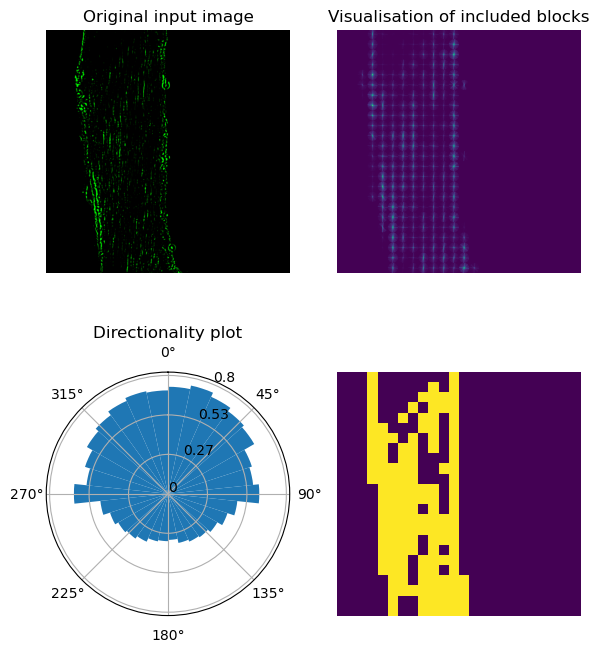

image file: 20240507 fkt19 P2 CTR R1.4-Deblurring_z27c1.tif
average direction  : -1.57 degrees.
standard deviation :  46.02 degrees
mean abs. deviation:  38.70 degrees


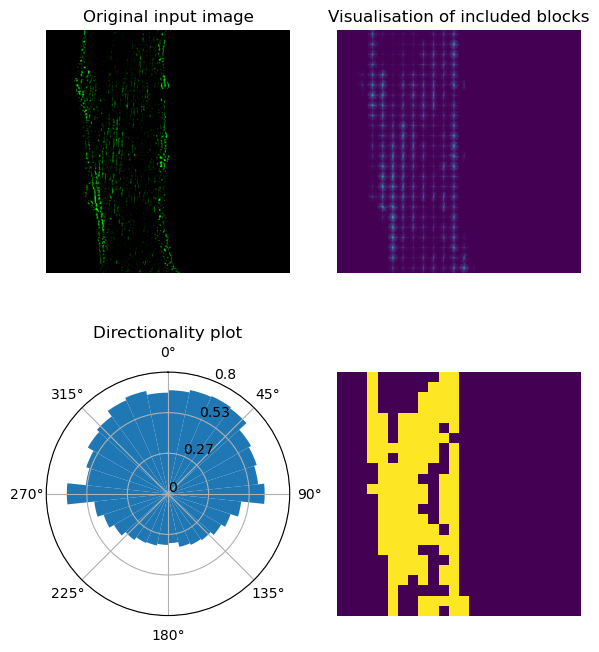

image file: 20240507 fkt19 P2 CTR R1.4-Deblurring_z28c1.tif
average direction  : -0.19 degrees.
standard deviation :  46.34 degrees
mean abs. deviation:  38.97 degrees


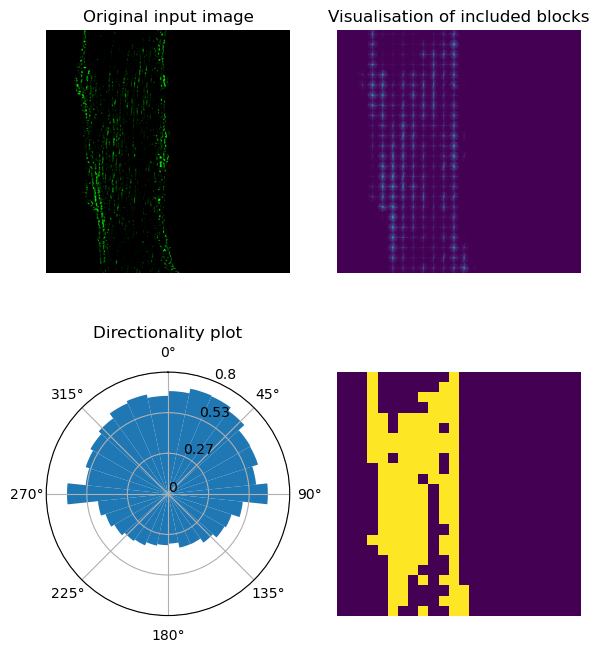

image file: 20240507 fkt19 P2 CTR R1.4-Deblurring_z30c1.tif
average direction  :  0.29 degrees.
standard deviation :  46.43 degrees
mean abs. deviation:  39.12 degrees


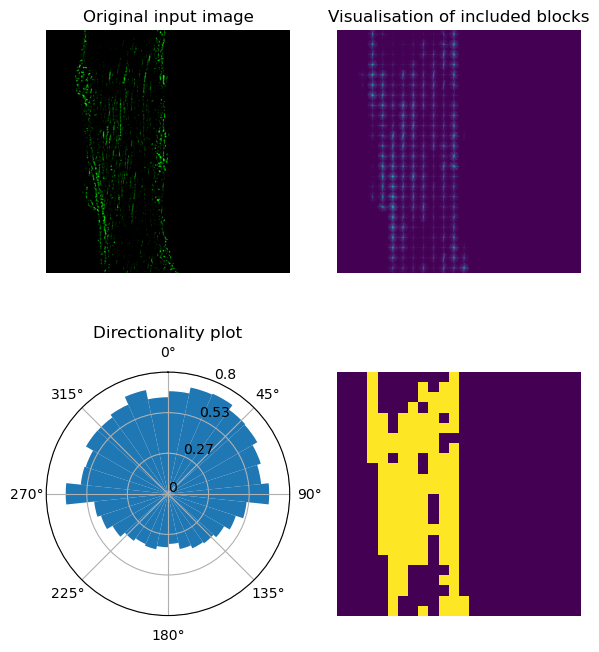

image file: 20240507 fkt19 P2 CTR R1.4-Deblurring_z31c1.tif
average direction  :  0.78 degrees.
standard deviation :  46.44 degrees
mean abs. deviation:  39.09 degrees


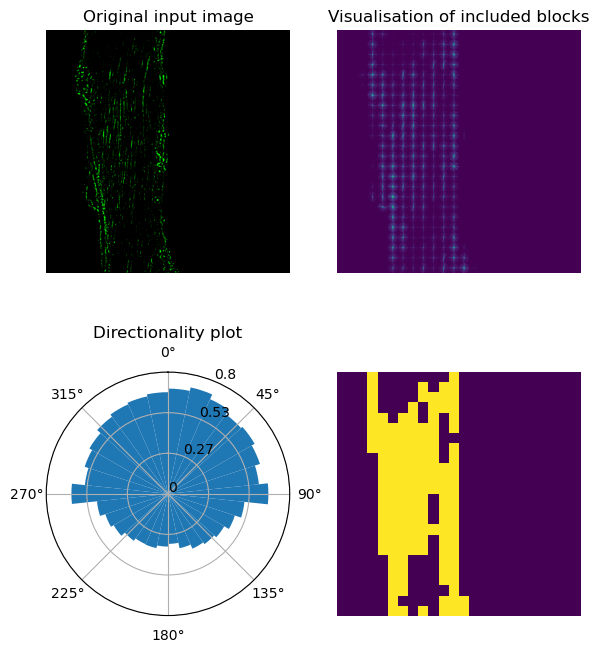

image file: 20240507 fkt19 P2 MS R1-Deblurring-21_z112c1.tif
average direction  : -7.83 degrees.
standard deviation :  44.13 degrees
mean abs. deviation:  36.54 degrees


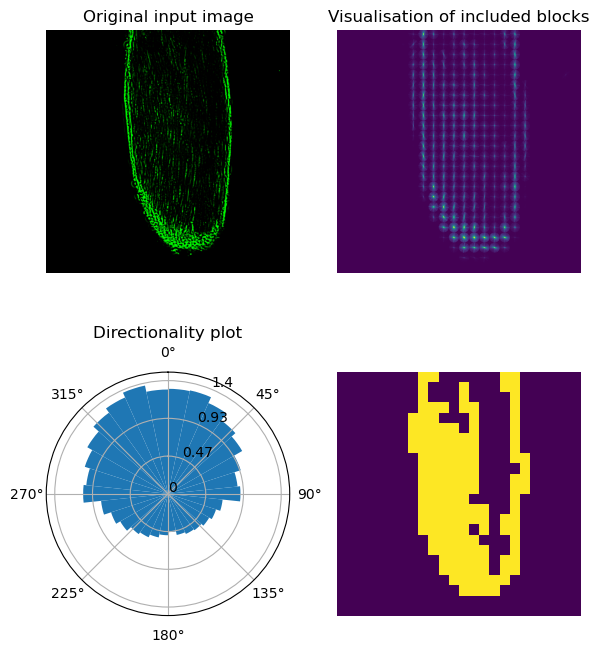

image file: 20240507 fkt19 P2 MS R1-Deblurring-21_z113c1.tif
average direction  : -7.49 degrees.
standard deviation :  44.34 degrees
mean abs. deviation:  36.70 degrees


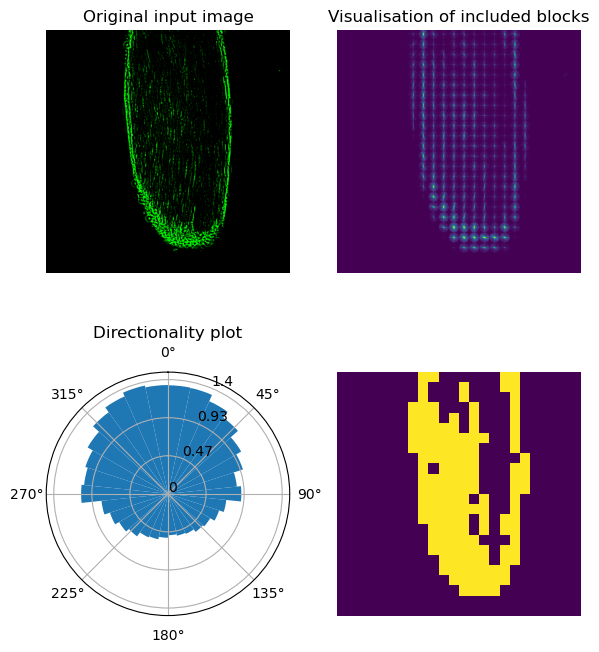

image file: 20240507 fkt19 P2 MS R1-Deblurring-21_z119c1.tif
average direction  : -6.81 degrees.
standard deviation :  43.76 degrees
mean abs. deviation:  36.00 degrees


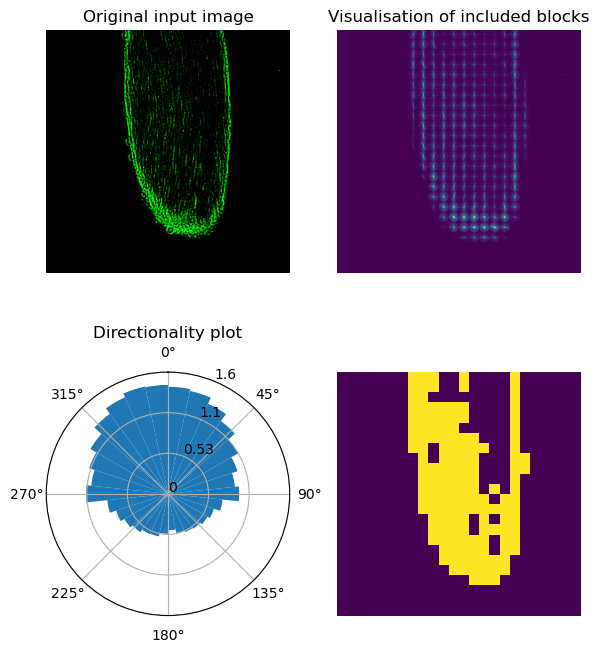

image file: 20240507 fkt19 P2 MS R1-Deblurring-21_z121c1.tif
average direction  : -6.42 degrees.
standard deviation :  44.01 degrees
mean abs. deviation:  36.29 degrees


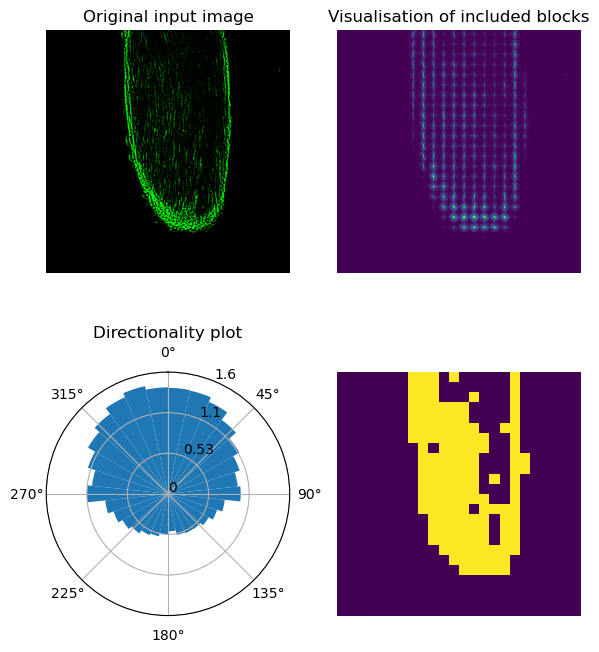

image file: 20240507 fkt19 P2 MS R1-Deblurring-21_z136c1.tif
average direction  : -9.46 degrees.
standard deviation :  44.00 degrees
mean abs. deviation:  36.31 degrees


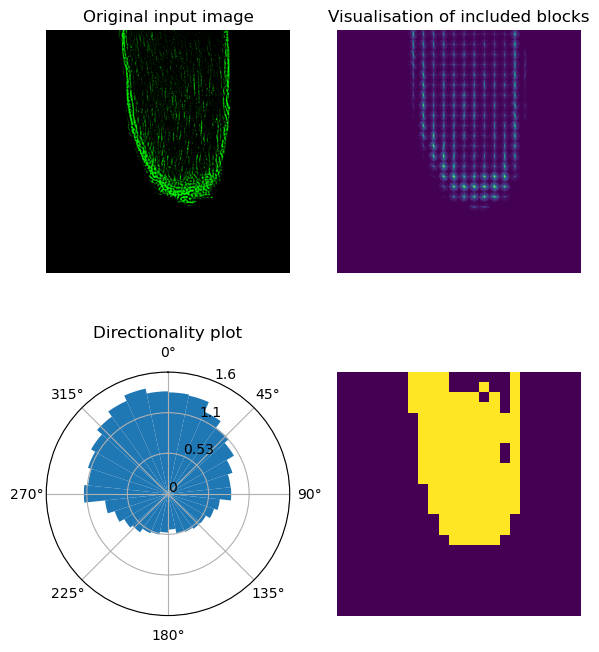

image file: 20240507 fkt19 P2 MS R1_3-Deblurring-20_z028c1.tif
average direction  : -6.52 degrees.
standard deviation :  43.23 degrees
mean abs. deviation:  35.45 degrees


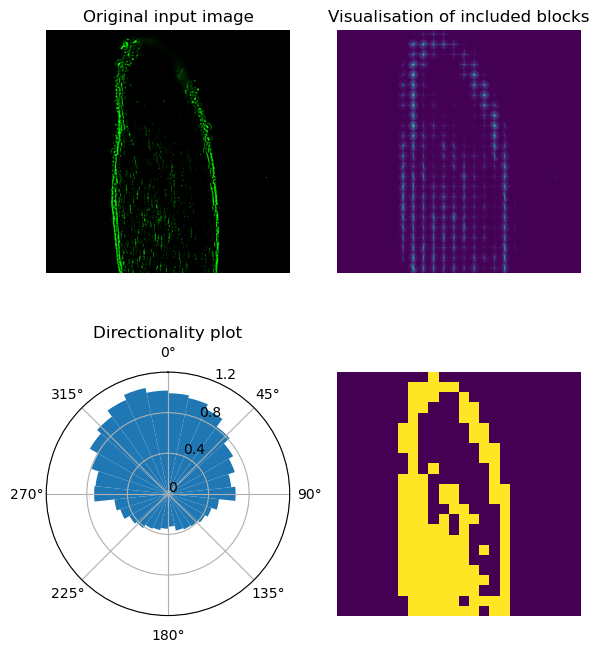

image file: 20240507 fkt19 P2 MS R1_3-Deblurring-20_z038c1.tif
average direction  : -6.15 degrees.
standard deviation :  42.42 degrees
mean abs. deviation:  34.59 degrees


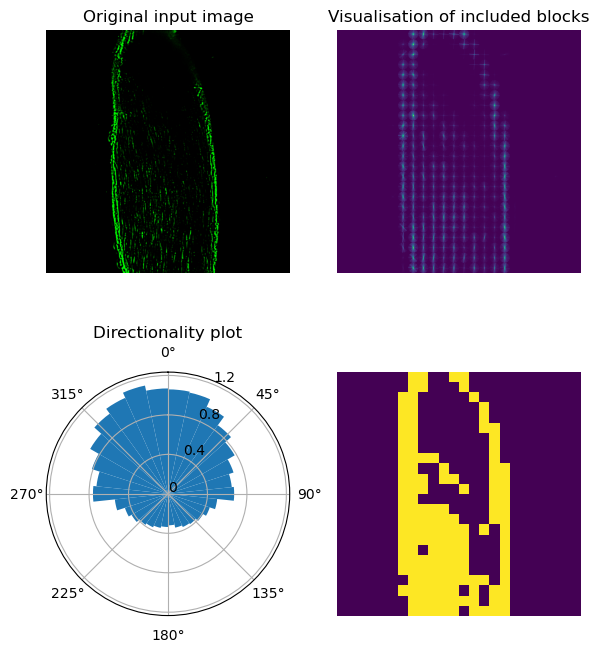

image file: 20240507 fkt19 P2 MS R1_3-Deblurring-20_z053c1.tif
average direction  : -7.74 degrees.
standard deviation :  41.32 degrees
mean abs. deviation:  33.61 degrees


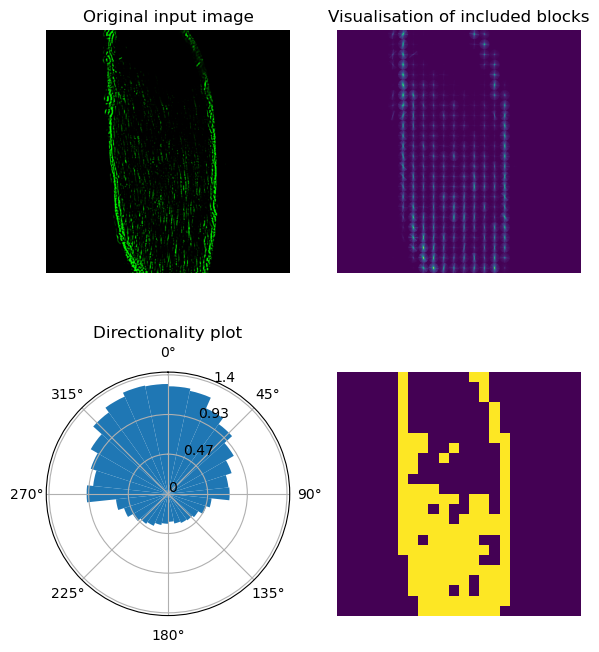

image file: 20240507 fkt19 P2 MS R1_3-Deblurring-20_z076c1.tif
average direction  : -15.09 degrees.
standard deviation :  44.18 degrees
mean abs. deviation:  36.75 degrees


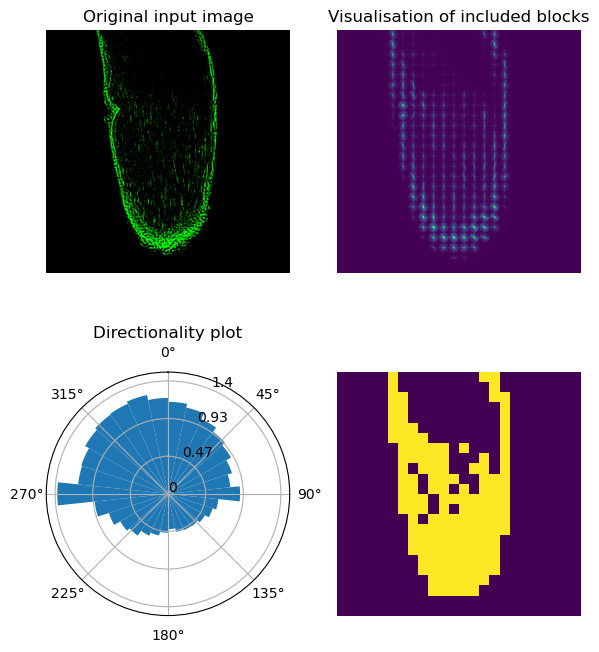

image file: 20240507 fkt19 P2 MS R1_3-Deblurring-20_z083c1.tif
average direction  : -14.16 degrees.
standard deviation :  44.91 degrees
mean abs. deviation:  37.50 degrees


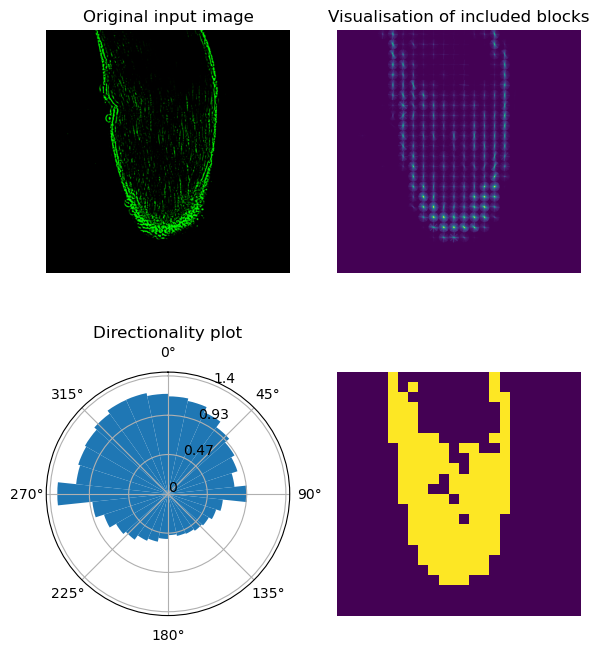

In [10]:
import pandas as pd
import time
import matplotlib.pyplot as plt

group_folders = ['CTR', 'MS']

df_statistics = pd.DataFrame()

for group in group_folders:
    image_path = os.path.join(root_folder, 'images-data', group)
    image_file_list = os.listdir(image_path)

    for image_file in image_file_list[:10]:

        t1 = time.time()

        image = load_and_prepare_image(image_path, image_file)

        hog_descriptor = HOGDescriptor(orientations=30, pixels_per_cell=(80, 80), cells_per_block=(1, 1), 
                                    channel_axis=-1)
        fd, hog_image = hog_descriptor.compute_hog(image, feature_vector=False)
        ## fd is of shape (cells_H_axis, cells_W_axis, Blocks_per_cell_H, Blocks_per_cell_W, n_orientations)

        # the plot_directional_histograms coolects the histogram distribution for every cell! Seems to work correctly now:
        fd_data = compute_directional_histogram(fd)

        intensities = fd_data.mean(1) # average entry per cell. Many of these are noisy: to be dropped
        threshold = np.percentile(intensities, 75)

        cells_to_consider = np.array([intensity > threshold for intensity in intensities])
        fd_data_final = fd_data[cells_to_consider,:].mean(0) # average ov every direction intensity across remaining cells

        # correct strong signal at 0 and 180 degrees (happens a lot with constant black backgournd)
        fd_data_final[0] = 0.5*(fd_data_final[1] + fd_data_final[-1])
        fd_data_final[round(len(fd_data_final)/2)] = 0.5*(fd_data_final[round(len(fd_data_final)/2)+1] + fd_data_final[round(len(fd_data_final)/2)-1])

        mean_angle_deg, std_dev_deg, avg_dev_deg = compute_average_direction(fd_data_final)

        print('image file:', image_file)
        print(f"average direction  : {mean_angle_deg:+.2f} degrees.".replace('+', ' '))
        print(f"standard deviation : {std_dev_deg:+.2f} degrees".replace('+', ' '))
        print(f"mean abs. deviation: {avg_dev_deg:+.2f} degrees".replace('+', ' '))

        fig = plt.figure(figsize=(6, 7))
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 4)
        ax4 = fig.add_subplot(2, 2, 3, projection='polar')

        ax1.axis('off')
        ax1.imshow(image)  # 'image' should be defined previously
        ax1.set_title('Original input image')

        ax2.axis('off')
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 4))
        ax2.imshow(hog_image_rescaled)
        # ax2.imshow(hog_image)
        ax2.set_title('Histogram of Oriented Gradients')
        
        ax3.axis('off')
        included_cells = cells_to_consider.reshape(fd.shape[0], fd.shape[1])
        im = ax3.imshow(included_cells)
        ax2.set_title('Visualisation of included blocks')

        # Pass the pre-defined axis object 'ax4' which is already set to be a polar plot
        N_ORS = hog_descriptor.get_orientations()
        estim_ymax = fd_data_final.max() 
        bin_angles, max_idx = polar_histogram(fd_data_final, ax4, n_orientations=N_ORS, y_lim=1.1*estim_ymax)
        ax4.set_title('Directionality plot')
        plt.tight_layout()
        plt.show()

        t2 = time.time()

        elapsed_seconds = int(t2 - t1)
        mins = elapsed_seconds // 60
        secs = elapsed_seconds % 60
        elapsed_time_formatted = f"{mins}:{secs:02d}"

        image_stats = pd.DataFrame({"group" : group,
                                    "image size" : str(image.shape),
                                    "elapsed_time (min:sec)": elapsed_time_formatted, #in seconds
                                    "avg. direction" : round(mean_angle_deg, 3),
                                    "std. deviation" : round(std_dev_deg, 3),
                                    "abs. deviation" : round(avg_dev_deg, 3)
                                    }, 
                            index = [image_file.split(".tif", 1)[0]])
        
        df_statistics = pd.concat([df_statistics, image_stats], axis=0) # [brackets] necessary if passing dictionary instead  

df_statistics.to_csv('HOG_statistics_draft.csv')
